In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
data = pd.read_csv("myo_raw_glove.csv")

In [4]:
data.head()

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Thumb,Index,Middle,Ring,Pinky
0,424,159,433,163,49,92,54,95,1023,1023,1023,1023,1023
1,442,185,495,184,61,99,58,116,1023,1023,1023,1023,1023
2,438,224,495,178,55,108,54,121,1023,1023,1023,1023,1023
3,391,260,553,176,56,97,50,121,1023,1015,1023,1023,1023
4,240,218,383,134,54,99,44,64,0,1015,1018,1023,1023


In [5]:
finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
myo_cols = ["Channel_1", "Channel_2", "Channel_3", "Channel_4", "Channel_5", "Channel_6", "Channel_7", "Channel_8"]

In [6]:
df = data.copy(deep=True)

<AxesSubplot:>

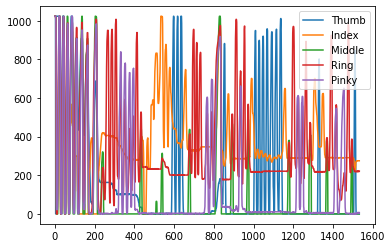

In [7]:
df[finger_names].plot()

<AxesSubplot:>

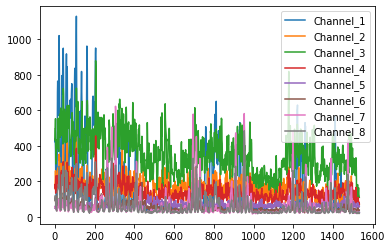

In [8]:
df[myo_cols].plot()

In [9]:
print("Correlation Matrix")
print()

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 10))

Correlation Matrix

Top Absolute Correlations
Channel_1  Channel_8    0.754583
Channel_7  Channel_8    0.726021
Channel_3  Channel_4    0.710998
Middle     Pinky        0.708324
Channel_6  Channel_7    0.673336
Channel_8  Ring         0.660545
Channel_1  Pinky        0.628341
Middle     Ring         0.625581
Channel_2  Channel_3    0.607180
Channel_6  Channel_8    0.591596
dtype: float64


# Making a full hand baseline

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5',
       'Channel_6', 'Channel_7', 'Channel_8']

X = df[x_cols]
y = df.drop(x_cols,1)

train_X, test_X, train_y, test_y = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25)

# Making our benchmark model
# Just predict the mean average number of bikes. 
y_train_mean = train_y.mean()

train_preds = np.ones(train_y.shape) * y_train_mean
preds = np.ones(test_y.shape) * y_train_mean

rmse = np.sqrt(mean_squared_error(train_y, train_preds))
print("Train RMSE: %f" % (rmse))

mae = mean_absolute_error(train_y, train_preds)
print("Train MAE: %f" % (mae))

rmse = np.sqrt(mean_squared_error(test_y, preds))
print("Test RMSE: %f" % (rmse))

mae = mean_absolute_error(test_y, preds)
print("Test MAE: %f" % (mae))

r2_score(test_y, preds)

Train RMSE: 274.396174
Train MAE: 215.544552
Test RMSE: 299.044585
Test MAE: 233.079801


-0.15969571168563118

In [11]:
X

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8
0,424,159,433,163,49,92,54,95
1,442,185,495,184,61,99,58,116
2,438,224,495,178,55,108,54,121
3,391,260,553,176,56,97,50,121
4,240,218,383,134,54,99,44,64
...,...,...,...,...,...,...,...,...
1528,24,77,165,79,55,38,23,20
1529,22,77,162,85,52,34,22,25
1530,25,66,127,78,56,38,23,21
1531,26,60,120,67,65,39,25,19


In [12]:
y

,Thumb,Index,Middle,Ring,Pinky
0,1023,1023,1023,1023,1023
1,1023,1023,1023,1023,1023
2,1023,1023,1023,1023,1023
3,1023,1015,1023,1023,1023
4,0,1015,1018,1023,1023
...,...,...,...,...,...
1528,0,275,0,221,7
1529,0,275,0,221,3
1530,0,275,0,221,7
1531,0,275,0,219,3


# Making a baseline Neural Network

In [16]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [20]:
finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
myo_cols = ["Channel_1", "Channel_2", "Channel_3", "Channel_4", "Channel_5", "Channel_6", "Channel_7", "Channel_8"]
x_cols = myo_cols
y_cols = finger_names

df = pd.read_csv("myo_raw_glove.csv")

# Rectification
X = abs(df[x_cols]).values
y = df.drop(x_cols,1).values

# Scaling
rel_hand_scaler = StandardScaler()
emg_scaler = StandardScaler()

ny = rel_hand_scaler.fit_transform(y)
nX = emg_scaler.fit_transform(X)

train_X, test_X, train_y, test_y = train_test_split(nX, ny, test_size=0.25)

In [21]:
model = Sequential()

# The Input Layer :
model.add(Dense(16,input_dim = train_X.shape[1], activation='relu'))

# The Hidden Layers :
model.add(Dense(32,activation='relu'))
model.add(Dense(64,activation='relu'))

# The Output Layer :
model.add(Dense(5,activation='relu'))

# Compile the network :
model.compile(loss='mse', optimizer='Adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 325       
Total params: 3,125
Trainable params: 3,125
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(train_X, train_y, epochs=200, batch_size=32, validation_data=(test_X, test_y))

Epoch 1/200
36/36 [==============================] - 1s 8ms/step - loss: 0.9475 - val_loss: 0.8756
Epoch 2/200
36/36 [==============================] - 0s 3ms/step - loss: 0.8106 - val_loss: 0.8216
Epoch 3/200
36/36 [==============================] - 0s 3ms/step - loss: 0.7885 - val_loss: 0.8024
Epoch 4/200
36/36 [==============================] - 0s 3ms/step - loss: 0.7593 - val_loss: 0.7973
Epoch 5/200
36/36 [==============================] - 0s 3ms/step - loss: 0.7305 - val_loss: 0.7921
Epoch 6/200
36/36 [==============================] - 0s 3ms/step - loss: 0.7553 - val_loss: 0.7796
Epoch 7/200
36/36 [==============================] - 0s 3ms/step - loss: 0.7054 - val_loss: 0.7752
Epoch 8/200
36/36 [==============================] - 0s 3ms/step - loss: 0.7742 - val_loss: 0.7759
Epoch 9/200
36/36 [==============================] - 0s 3ms/step - loss: 0.7780 - val_loss: 0.7701
Epoch 10/200
36/36 [==============================] - 0s 3ms/step - loss: 0.7296 - val_loss: 0.7659
Epoch 11/

36/36 [==============================] - 0s 3ms/step - loss: 0.5218 - val_loss: 0.7189
Epoch 84/200
36/36 [==============================] - 0s 3ms/step - loss: 0.5525 - val_loss: 0.7281
Epoch 85/200
36/36 [==============================] - 0s 3ms/step - loss: 0.5300 - val_loss: 0.7235
Epoch 86/200
36/36 [==============================] - 0s 3ms/step - loss: 0.5126 - val_loss: 0.7317
Epoch 87/200
36/36 [==============================] - 0s 3ms/step - loss: 0.5084 - val_loss: 0.7267
Epoch 88/200
36/36 [==============================] - 0s 3ms/step - loss: 0.5307 - val_loss: 0.7305
Epoch 89/200
36/36 [==============================] - 0s 3ms/step - loss: 0.5219 - val_loss: 0.7212
Epoch 90/200
36/36 [==============================] - 0s 3ms/step - loss: 0.5350 - val_loss: 0.7172
Epoch 91/200
36/36 [==============================] - 0s 3ms/step - loss: 0.5251 - val_loss: 0.7200
Epoch 92/200
36/36 [==============================] - 0s 3ms/step - loss: 0.5008 - val_loss: 0.7300
Epoch 93/200


36/36 [==============================] - 0s 3ms/step - loss: 0.4741 - val_loss: 0.7398
Epoch 165/200
36/36 [==============================] - 0s 3ms/step - loss: 0.4699 - val_loss: 0.7387
Epoch 166/200
36/36 [==============================] - 0s 3ms/step - loss: 0.4775 - val_loss: 0.7367
Epoch 167/200
36/36 [==============================] - 0s 3ms/step - loss: 0.4788 - val_loss: 0.7355
Epoch 168/200
36/36 [==============================] - 0s 3ms/step - loss: 0.4779 - val_loss: 0.7421
Epoch 169/200
36/36 [==============================] - 0s 3ms/step - loss: 0.4830 - val_loss: 0.7352
Epoch 170/200
36/36 [==============================] - 0s 3ms/step - loss: 0.4861 - val_loss: 0.7481
Epoch 171/200
36/36 [==============================] - 0s 3ms/step - loss: 0.4892 - val_loss: 0.7434
Epoch 172/200
36/36 [==============================] - 0s 3ms/step - loss: 0.4720 - val_loss: 0.7423
Epoch 173/200
36/36 [==============================] - 0s 3ms/step - loss: 0.5095 - val_loss: 0.7540
Epoc

In [23]:
# Evaluate the model on the test data
mse = model.evaluate(test_X, test_y)
mse

12/12 [==============================] - 0s 1ms/step - loss: 0.7452


0.7451503276824951

In [35]:
# Training Set
train_preds = model.predict(train_X) # scaled inputs here

# Scaling back the prediction
train_preds = rel_hand_scaler.inverse_transform(train_preds)
# Scaling back the goals
train_goal = rel_hand_scaler.inverse_transform(train_y)

MSE = mean_squared_error(train_goal, train_preds)  # first 2 steps, combined
print("Train MSE: ", MSE)
print("Train RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(train_goal, train_preds)
print("Train MAE: ", MAE)

print()
# Test Set
test_preds = model.predict(test_X) # scaled inputs here

# Scaling back the prediction
test_preds = rel_hand_scaler.inverse_transform(test_preds)
# Scaling back the goals
test_goal = rel_hand_scaler.inverse_transform(test_y)

MSE = mean_squared_error(test_goal, test_preds)  # first 2 steps, combined
print("Test MSE: ", MSE)
print("Test RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(test_goal, test_preds)
print("Test MAE: ", MAE)

Train MSE:  34283.65005004404
Train RMSE:  185.15844579722534
Train MAE:  141.13389097500925

Test MSE:  50224.85106411467
Test RMSE:  224.10901602593918
Test MAE:  169.5635722398758


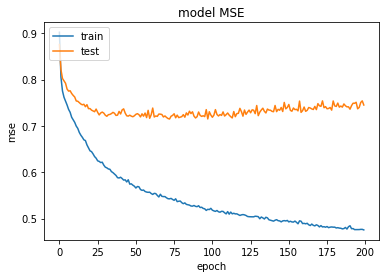

In [36]:
# summarize history for loss
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model MSE')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot the predicted vs ground truth

In [37]:
y_cols_pred = []
for i in y_cols:
    y_cols_pred.append(i+"_pred")
    
preds = pd.DataFrame(train_preds, columns=y_cols_pred)
goal = pd.DataFrame(train_goal, columns=y_cols)
vis = pd.concat([preds, goal], axis=1)

In [38]:
vis

,Thumb_pred,Index_pred,Middle_pred,Ring_pred,Pinky_pred,Thumb,Index,Middle,Ring,Pinky
0,185.339203,356.450104,100.969994,353.790619,192.311569,421.0,88.0,0.0,22.0,3.0
1,185.339203,356.450104,100.969994,353.790619,532.479675,0.0,291.0,0.0,562.0,546.0
2,185.339203,356.450104,100.969994,575.763184,291.199554,15.0,347.0,0.0,516.0,197.0
3,185.339203,356.450104,100.969994,353.790619,144.859756,0.0,327.0,0.0,295.0,3.0
4,185.339203,356.450104,100.969994,353.790619,144.859756,0.0,327.0,0.0,216.0,7.0
...,...,...,...,...,...,...,...,...,...,...
1144,185.339203,356.450104,100.969994,465.602478,215.641785,483.0,0.0,127.0,421.0,86.0
1145,185.339203,356.450104,100.969994,353.790619,144.859756,234.0,282.0,0.0,221.0,7.0
1146,185.339203,356.450104,100.969994,353.790619,144.859756,100.0,294.0,0.0,142.0,11.0
1147,185.339203,356.450104,100.969994,804.846680,144.859756,0.0,291.0,0.0,902.0,3.0


<AxesSubplot:>

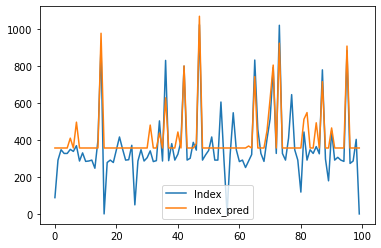

In [40]:
finger = "Index"
vis[[finger,finger+'_pred']].iloc[0:100].plot()

### Save the model and the scalers

In [41]:
import joblib

model_name = "NNBasic"

model.save(f"../models/{model_name}.h5")
# Save hand scaler to file.
# Scales the output of the network, the relative position of the hand, min_max
joblib.dump(rel_hand_scaler, f'../models/{model_name}-Hand.gz')

# Scales the input to the network, the emg data. 
joblib.dump(emg_scaler, f'../models/{model_name}-EMG.gz')

['../models/NNBasic-EMG.gz']

In [43]:
# Making a prediction in the prediction script.
from keras.models import load_model
model = load_model(f"../models/{model_name}.h5")

input_scaler = joblib.load(f'../models/{model_name}-EMG.gz')
output_scaler = joblib.load(f'../models/{model_name}-Hand.gz')

# Get some input data
semg_input = np.array([[ 31, 140, 140,  83,  42,  30,  22,  21]])
# Scale the input
scaled_input = input_scaler.transform(semg_input)
# Get a prediction
pred = model.predict(scaled_input)
# Scale it back to a value
scaled_pred = output_scaler.inverse_transform(pred)
scaled_pred

array([[185.3392 , 356.4501 , 100.96999, 353.79062, 144.85976]],
      dtype=float32)

In [44]:
prediction = model.predict(test_X) # scaled inputs here
print(prediction)

# Scaling back the prediction
preds = rel_hand_scaler.inverse_transform(prediction)
# Scaling back the goals
goal = rel_hand_scaler.inverse_transform(test_y)

MSE = mean_squared_error(goal, preds)  # first 2 steps, combined
print("MSE: ", MSE)
print("RMSE: ", np.sqrt(MSE))  # 3rd step
MAE = mean_absolute_error(goal, preds)
print("MAE: ", MAE)

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.1183424  0.        ]
 [0.         0.         0.5390486  0.17695205 0.5805038 ]
 ...
 [0.         0.42288837 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
MSE:  50224.85106411467
RMSE:  224.10901602593918
MAE:  169.5635722398758
